# Notebook to correct quenching from a glider dataset

The idea is to leverage the number of observation in a glider dataset to achieve a quenching correction using the night time profile as our training dataset of "unquenched profiles".

1) Binary classification of quenched profiles. The mid-day profiles will be labelled as quenched and mid-night profiles will be labeled as unquenched to predict if dusk and dawn profiles are quenched. 
2) Second binary classification to predict the quenched layer depth based on F/bbp values. 
3) Predict a F/bbp factor based on bbp, T, S, depth, Doy. Training is realised on the "unquenched database" and new prediction is made on quenched layers. 
4) Apply the ratio predicted before on the quench layer

## 1. Building the dataset 

Open the gliders dataset. I want to end up with one tidy table composed of profile id, doy, time, depth, T, S, F, bbp.
I will further derive a "day_period" variable that will correspond to mid-day, dusk, mid-night or dawn. TBD what time lag should be before/after sunset and sunset to consider mid-day or mid-night.

In [1]:
import xarray as xr
import polars as pl
import glob

# Get list of NetCDF files
nc_files = glob.glob("C:/Users/flapet/OneDrive - NOC/Documents/IDAPro/lib/db_building/data/glider/nc_profiled/*.nc")

# Read and concatenate datasets
for file in nc_files:
    ds = xr.open_dataset(file, decode_times=True)
    glider_name = ds.attrs.get("trajectory").split("_")[0]
    # Select variables of interest
    vars_of_interest = ["TIME", "DEPTH", "TEMP", "CHLA", "BBP700", "ABS_SALINITY", "PROFILE_NUMBER", "LATITUDE", "LONGITUDE"]
    ds_sel = ds[vars_of_interest]
    # Convert to pandas DataFrame, then to polars DataFrame
    df_pd = ds_sel.to_dataframe().reset_index()
    df_pl = pl.from_pandas(df_pd)

    #Use only profiling data (-1 is surfacing behavior)
    df_pl = df_pl.filter(pl.col("PROFILE_NUMBER") > 0)

    df_pl = df_pl.with_columns((pl.col("PROFILE_NUMBER").cast(pl.String) + "_" + glider_name).alias("profile_id"))
    print(f"{file} processed, shape: {df_pl.shape}")

    # Concatenate DataFrames
    if 'df_concat' in locals():
        df_concat = pl.concat([df_concat, df_pl])
    else:
        df_concat = df_pl

df_concat

C:/Users/flapet/OneDrive - NOC/Documents/IDAPro/lib/db_building/data/glider/nc_profiled\Cabot_645_Profiled.nc processed, shape: (1438541, 11)
C:/Users/flapet/OneDrive - NOC/Documents/IDAPro/lib/db_building/data/glider/nc_profiled\Churchill_647_Profiled.nc processed, shape: (1142019, 11)
C:/Users/flapet/OneDrive - NOC/Documents/IDAPro/lib/db_building/data/glider/nc_profiled\Doombar_648_Profiled.nc processed, shape: (1952630, 11)
C:/Users/flapet/OneDrive - NOC/Documents/IDAPro/lib/db_building/data/glider/nc_profiled\Nelson_646_Profiled.nc processed, shape: (1951435, 11)


N_MEASUREMENTS,TIME,DEPTH,TEMP,CHLA,BBP700,ABS_SALINITY,PROFILE_NUMBER,LATITUDE,LONGITUDE,profile_id
i64,datetime[ns],f64,f32,f32,f32,f64,f64,f32,f32,str
322,2024-05-28 12:58:56.229522944,null,null,null,null,null,1.0,null,null,"""1.0_Cabot"""
323,2024-05-28 12:59:22.159026944,null,null,18.98,0.007497,null,1.0,60.000038,-24.001507,"""1.0_Cabot"""
324,2024-05-28 12:59:26.196716032,null,null,null,null,null,1.0,60.000038,-24.001507,"""1.0_Cabot"""
325,2024-05-28 12:59:29.217712896,10.193252,8.9538,null,null,0.000369,1.0,60.000038,-24.001507,"""1.0_Cabot"""
326,2024-05-28 12:59:32.235504896,null,null,18.9727,0.007497,null,1.0,60.000038,-24.001507,"""1.0_Cabot"""
…,…,…,…,…,…,…,…,…,…,…
1993522,2024-09-28 11:35:12.820740096,-1.782856,10.865,null,null,35.383698,1591.0,61.187576,-21.584673,"""1591.0_Nelson"""
1993523,2024-09-28 11:35:13.832550400,null,null,null,null,null,1591.0,61.187576,-21.584675,"""1591.0_Nelson"""
1993524,2024-09-28 11:35:20.878722816,null,null,0.2774,0.000099,null,1591.0,61.187576,-21.584688,"""1591.0_Nelson"""


In [2]:
# Interpolate DEPTH, TEMP, and ABS_SALINITY per profile_id along TIME
df_concat = (
    df_concat
    .sort(["profile_id", "TIME"])
    .with_columns([
        pl.col("DEPTH").interpolate().over("profile_id").alias("DEPTH_interp"),
        pl.col("TEMP").interpolate().over("profile_id").alias("TEMP_interp"),
        pl.col("ABS_SALINITY").interpolate().over("profile_id").alias("ABS_SALINITY_interp"),
    ])
)

In [3]:
# Count rows where CHLA and BBP700 are not null, but at least one of the interp columns is null
count = (
    df_concat
    .filter(
        (pl.col("CHLA").is_not_null()) &
        (pl.col("BBP700").is_not_null()) &
        (pl.col("LATITUDE").is_not_null()) &
        (pl.col("LONGITUDE").is_not_null()) &
        (
            pl.col("DEPTH_interp").is_null() |
            pl.col("TEMP_interp").is_null() |
            pl.col("ABS_SALINITY_interp").is_null()
        )
    )
    .height
)
print(f"Number of rows with CHLA and BBP700 but missing one interp variable: {count}")

Number of rows with CHLA and BBP700 but missing one interp variable: 8451


In [14]:
# Filter out rows with NA in required columns and drop original columns
df_filtered = (
    df_concat
    .filter(
        pl.col("CHLA").is_not_null() &
        pl.col("BBP700").is_not_null() &
        pl.col("DEPTH_interp").is_not_null() &
        pl.col("TEMP_interp").is_not_null() &
        pl.col("ABS_SALINITY_interp").is_not_null() &
        (pl.col("LATITUDE").is_not_null()) &
        (pl.col("LONGITUDE").is_not_null())
    )
    .drop(["DEPTH", "TEMP", "ABS_SALINITY"])
    .rename({
        "DEPTH_interp": "DEPTH",
        "TEMP_interp": "TEMP",
        "ABS_SALINITY_interp": "ABS_SALINITY"
    })
)
df_filtered

N_MEASUREMENTS,TIME,CHLA,BBP700,PROFILE_NUMBER,LATITUDE,LONGITUDE,profile_id,DEPTH,TEMP,ABS_SALINITY
i64,datetime[ns],f32,f32,f64,f32,f32,str,f64,f32,f64
326,2024-05-28 12:59:32.235504896,18.9727,0.007497,1.0,60.000038,-24.001507,"""1.0_Cabot""",10.18995,8.951067,0.000369
330,2024-05-28 12:59:42.302062848,18.9727,0.007497,1.0,60.000038,-24.001507,"""1.0_Cabot""",10.183345,8.94232,0.000369
334,2024-05-28 12:59:52.421722112,18.9946,0.007497,1.0,60.000038,-24.001507,"""1.0_Cabot""",10.186647,8.9334,0.00037
337,2024-05-28 13:00:02.500366336,18.987301,0.007497,1.0,60.000038,-24.001507,"""1.0_Cabot""",10.18995,8.9259,0.00037
340,2024-05-28 13:00:12.561890304,18.9727,0.007497,1.0,60.000038,-24.001507,"""1.0_Cabot""",10.185822,8.929325,0.00037
…,…,…,…,…,…,…,…,…,…,…
1374725,2024-08-19 17:30:46.156890112,0.9782,0.000329,999.0,62.47134,-16.046728,"""999.0_Nelson""",-5.793653,12.247167,35.358
1374729,2024-08-19 17:30:56.291320320,0.8979,0.000336,999.0,62.471344,-16.046844,"""999.0_Nelson""",-4.714164,12.247167,35.357858
1374731,2024-08-19 17:31:06.436065280,0.9198,0.000321,999.0,62.471352,-16.046959,"""999.0_Nelson""",-4.179369,12.246634,35.356385


In [15]:
# Filter profiles with more than 100 observations
profile_counts = (
    df_filtered
    .group_by("profile_id")
    .agg([
        pl.len().alias("n_obs"),
        pl.col("DEPTH").min().alias("min_depth"),
        pl.col("DEPTH").max().alias("max_depth"),
        pl.col("DEPTH").abs().min().alias("min_abs_depth"),
        pl.col("DEPTH").abs().max().alias("max_abs_depth"),
    ])
)

# Apply filtering conditions
valid_profiles = (
    profile_counts
    .filter(
        (pl.col("n_obs") > 100)
    )
    .select("profile_id")
    .to_series()
    .to_list()
)

df_filtered = df_filtered.filter(pl.col("profile_id").is_in(valid_profiles))

In [ ]:
df_filtered

In [16]:
import datetime

df_filtered = (
    df_filtered
    .with_columns([
        pl.col("TIME").dt.date().alias("DATE"),
        pl.col("TIME").dt.ordinal_day().alias("DOY"),
        pl.col("TIME").dt.time().alias("TIME_ONLY"),
    ])
)

In [17]:
from astral.sun import sun
from astral import LocationInfo
import pytz

# Step 1: Compute unique dates with average lat/lon
date_latlon = (
    df_filtered
    .groupby("DATE")
    .agg([
        pl.col("LATITUDE").mean().alias("LAT_MEAN"),
        pl.col("LONGITUDE").mean().alias("LON_MEAN")
    ])
)

# Step 2: Compute sunrise and sunset for each date/lat/lon
def compute_sun_times(row):
    date = row["DATE"]
    lat = row["LAT_MEAN"]
    lon = row["LON_MEAN"]
    try:
        location = LocationInfo(latitude=lat, longitude=lon)
        s = sun(location.observer, date=date, tzinfo=pytz.UTC)
        return s["sunrise"].time().isoformat(), s["sunset"].time().isoformat()
    except Exception:
        return None, None

rows = date_latlon.to_dicts()
sun_times = [compute_sun_times(row) for row in rows]
sunrise_list, sunset_list = zip(*sun_times)

date_latlon = date_latlon.with_columns([
    pl.Series("SUNRISE", sunrise_list),
    pl.Series("SUNSET", sunset_list),
])

date_latlon = date_latlon.with_columns([
    pl.col("SUNRISE").apply(lambda x: datetime.time.fromisoformat(x) if x is not None else None).alias("SUNRISE"),
    pl.col("SUNSET").apply(lambda x: datetime.time.fromisoformat(x) if x is not None else None).alias("SUNSET"),
])

# Step 3: Left join sunrise/sunset info to df_filtered
df_with_sun = df_filtered.join(date_latlon.select(["DATE", "SUNRISE", "SUNSET"]), on="DATE", how="left")
df_with_sun

C:\Users\flapet\AppData\Local\Temp\ipykernel_26480\1308002821.py:8: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  .groupby("DATE")
C:\Users\flapet\AppData\Local\Temp\ipykernel_26480\1308002821.py:37: DeprecationWarning: `apply` is deprecated. It has been renamed to `map_elements`.
  pl.col("SUNRISE").apply(lambda x: datetime.time.fromisoformat(x) if x is not None else None).alias("SUNRISE"),
C:\Users\flapet\AppData\Local\Temp\ipykernel_26480\1308002821.py:38: DeprecationWarning: `apply` is deprecated. It has been renamed to `map_elements`.
  pl.col("SUNSET").apply(lambda x: datetime.time.fromisoformat(x) if x is not None else None).alias("SUNSET"),


N_MEASUREMENTS,TIME,CHLA,BBP700,PROFILE_NUMBER,LATITUDE,LONGITUDE,profile_id,DEPTH,TEMP,ABS_SALINITY,DATE,DOY,TIME_ONLY,SUNRISE,SUNSET
i64,datetime[ns],f32,f32,f64,f32,f32,str,f64,f32,f64,date,i16,time,time,time
6412,2024-05-28 23:37:04.737335296,0.0,0.000095,10.0,59.983898,-23.9601,"""10.0_Churchill…",-646.127372,6.229175,35.228666,2024-05-28,149,23:37:04.737335296,04:31:27.821020,22:36:15.674985
6414,2024-05-28 23:37:14.903015168,0.0,0.000093,10.0,59.983902,-23.960108,"""10.0_Churchill…",-645.25019,6.242167,35.229472,2024-05-28,149,23:37:14.903015168,04:31:27.821020,22:36:15.674985
6418,2024-05-28 23:37:24.998016768,-0.0142,0.000093,10.0,59.983906,-23.960114,"""10.0_Churchill…",-643.143615,6.270634,35.230924,2024-05-28,149,23:37:24.998016768,04:31:27.821020,22:36:15.674985
6420,2024-05-28 23:37:35.079681024,0.0071,0.000093,10.0,59.98391,-23.960117,"""10.0_Churchill…",-641.965236,6.28225,35.231634,2024-05-28,149,23:37:35.079681024,04:31:27.821020,22:36:15.674985
6424,2024-05-28 23:37:45.278412288,-0.0071,0.000098,10.0,59.983913,-23.960125,"""10.0_Churchill…",-640.133406,6.29045,35.232209,2024-05-28,149,23:37:45.278412288,04:31:27.821020,22:36:15.674985
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
1374725,2024-08-19 17:30:46.156890112,0.9782,0.000329,999.0,62.47134,-16.046728,"""999.0_Nelson""",-5.793653,12.247167,35.358,2024-08-19,232,17:30:46.156890112,05:18:08.105802,20:54:58.142935
1374729,2024-08-19 17:30:56.291320320,0.8979,0.000336,999.0,62.471344,-16.046844,"""999.0_Nelson""",-4.714164,12.247167,35.357858,2024-08-19,232,17:30:56.291320320,05:18:08.105802,20:54:58.142935
1374731,2024-08-19 17:31:06.436065280,0.9198,0.000321,999.0,62.471352,-16.046959,"""999.0_Nelson""",-4.179369,12.246634,35.356385,2024-08-19,232,17:31:06.436065280,05:18:08.105802,20:54:58.142935


In [18]:
import datetime

def get_day_period(row):
    time_only = row["TIME_ONLY"]
    sunrise = row["SUNRISE"]
    sunset = row["SUNSET"]

    # If any value is None, return null
    if time_only is None or sunrise is None or sunset is None:
        return None

    # Convert to datetime.time if needed
    if not isinstance(time_only, datetime.time):
        try:
            time_only = datetime.time.fromisoformat(str(time_only))
        except Exception:
            return None
    if not isinstance(sunrise, datetime.time):
        try:
            sunrise = datetime.time.fromisoformat(str(sunrise))
        except Exception:
            return None
    if not isinstance(sunset, datetime.time):
        try:
            sunset = datetime.time.fromisoformat(str(sunset))
        except Exception:
            return None

    def seconds_diff(t1, t2):
        dt1 = datetime.datetime.combine(datetime.date(1,1,1), t1)
        dt2 = datetime.datetime.combine(datetime.date(1,1,1), t2)
        return (dt1 - dt2).total_seconds()

    two_hours = 2 * 3600
    one_hour = 2 * 3600

    if 0 <= seconds_diff(time_only, sunrise) <= one_hour:
        return "dawn"
    elif 0 <= seconds_diff(sunset, time_only) <= one_hour:
        return "dusk"
    elif seconds_diff(time_only, sunset) > one_hour or seconds_diff(time_only, sunrise) < -one_hour:
        return "mid-night"
    else:
        return "mid-day"

df_with_sun = df_with_sun.with_columns(
    pl.struct(["TIME_ONLY", "SUNRISE", "SUNSET"]).apply(get_day_period).alias("day_period")
)

df_with_sun

C:\Users\flapet\AppData\Local\Temp\ipykernel_26480\271026701.py:47: DeprecationWarning: `apply` is deprecated. It has been renamed to `map_elements`.
  pl.struct(["TIME_ONLY", "SUNRISE", "SUNSET"]).apply(get_day_period).alias("day_period")


N_MEASUREMENTS,TIME,CHLA,BBP700,PROFILE_NUMBER,LATITUDE,LONGITUDE,profile_id,DEPTH,TEMP,ABS_SALINITY,DATE,DOY,TIME_ONLY,SUNRISE,SUNSET,day_period
i64,datetime[ns],f32,f32,f64,f32,f32,str,f64,f32,f64,date,i16,time,time,time,str
6412,2024-05-28 23:37:04.737335296,0.0,0.000095,10.0,59.983898,-23.9601,"""10.0_Churchill…",-646.127372,6.229175,35.228666,2024-05-28,149,23:37:04.737335296,04:31:27.821020,22:36:15.674985,"""mid-day"""
6414,2024-05-28 23:37:14.903015168,0.0,0.000093,10.0,59.983902,-23.960108,"""10.0_Churchill…",-645.25019,6.242167,35.229472,2024-05-28,149,23:37:14.903015168,04:31:27.821020,22:36:15.674985,"""mid-day"""
6418,2024-05-28 23:37:24.998016768,-0.0142,0.000093,10.0,59.983906,-23.960114,"""10.0_Churchill…",-643.143615,6.270634,35.230924,2024-05-28,149,23:37:24.998016768,04:31:27.821020,22:36:15.674985,"""mid-day"""
6420,2024-05-28 23:37:35.079681024,0.0071,0.000093,10.0,59.98391,-23.960117,"""10.0_Churchill…",-641.965236,6.28225,35.231634,2024-05-28,149,23:37:35.079681024,04:31:27.821020,22:36:15.674985,"""mid-day"""
6424,2024-05-28 23:37:45.278412288,-0.0071,0.000098,10.0,59.983913,-23.960125,"""10.0_Churchill…",-640.133406,6.29045,35.232209,2024-05-28,149,23:37:45.278412288,04:31:27.821020,22:36:15.674985,"""mid-day"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
1374725,2024-08-19 17:30:46.156890112,0.9782,0.000329,999.0,62.47134,-16.046728,"""999.0_Nelson""",-5.793653,12.247167,35.358,2024-08-19,232,17:30:46.156890112,05:18:08.105802,20:54:58.142935,"""mid-day"""
1374729,2024-08-19 17:30:56.291320320,0.8979,0.000336,999.0,62.471344,-16.046844,"""999.0_Nelson""",-4.714164,12.247167,35.357858,2024-08-19,232,17:30:56.291320320,05:18:08.105802,20:54:58.142935,"""mid-day"""
1374731,2024-08-19 17:31:06.436065280,0.9198,0.000321,999.0,62.471352,-16.046959,"""999.0_Nelson""",-4.179369,12.246634,35.356385,2024-08-19,232,17:31:06.436065280,05:18:08.105802,20:54:58.142935,"""mid-day"""


In [19]:
# Count unique profile_id per day_period in df_filtered
profile_count = (
    df_with_sun
    .group_by("day_period")
    .agg([
        pl.col("profile_id").n_unique().alias("n_profiles")
    ])
    .sort("day_period")
)

profile_count

day_period,n_profiles
str,u32
null,40
"""dawn""",729
"""dusk""",696
"""mid-day""",3835
"""mid-night""",1018


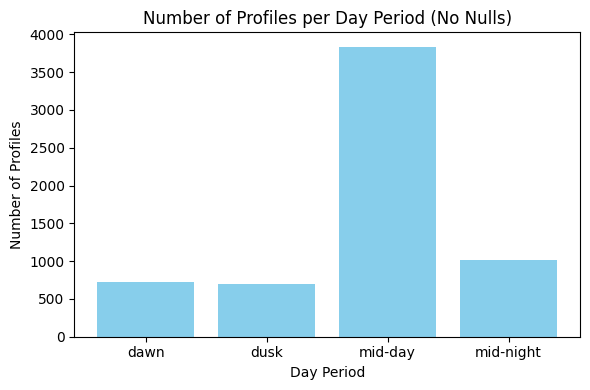

In [20]:
# Remove rows with null day_period
df_no_null = df_with_sun.filter(pl.col("day_period").is_not_null())

# Count unique profile_id per day_period
profile_count_no_null = (
    df_no_null
    .group_by("day_period")
    .agg([
        pl.col("profile_id").n_unique().alias("n_profiles")
    ])
    .sort("day_period")
)

# Bar plot
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.bar(profile_count_no_null["day_period"], profile_count_no_null["n_profiles"], color="skyblue")
plt.xlabel("Day Period")
plt.ylabel("Number of Profiles")
plt.title("Number of Profiles per Day Period (No Nulls)")
plt.tight_layout()
plt.show()

## Smoothing Chla and BBP profiles

In [21]:
import glidertools as gt
bbp_baseline, bbp_spikes = gt.cleaning.despike(df_with_sun['BBP700'], 7, spike_method='minmax')

C:\Users\flapet\OneDrive - NOC\Documents\IDAPro\lib\GliderTools\glidertools\helpers.py:76: GliderToolsWarning: Primary input variable is not xr.DataArray data type - no metadata to pass on.
  warnings.warn(msg, category=GliderToolsWarning)


In [22]:

# Despike BBP700
bbp_baseline, _ = gt.cleaning.despike(df_with_sun['BBP700'], 7, spike_method='minmax')
# Despike CHLA
chla_baseline, _ = gt.cleaning.despike(df_with_sun['CHLA'], 7, spike_method='minmax')

# Add new columns to df_with_sun
df_with_sun = df_with_sun.with_columns([
    pl.Series("bbp_clean", bbp_baseline),
    pl.Series("chla_clean", chla_baseline)
])



C:\Users\flapet\OneDrive - NOC\Documents\IDAPro\lib\GliderTools\glidertools\helpers.py:76: GliderToolsWarning: Primary input variable is not xr.DataArray data type - no metadata to pass on.
  warnings.warn(msg, category=GliderToolsWarning)


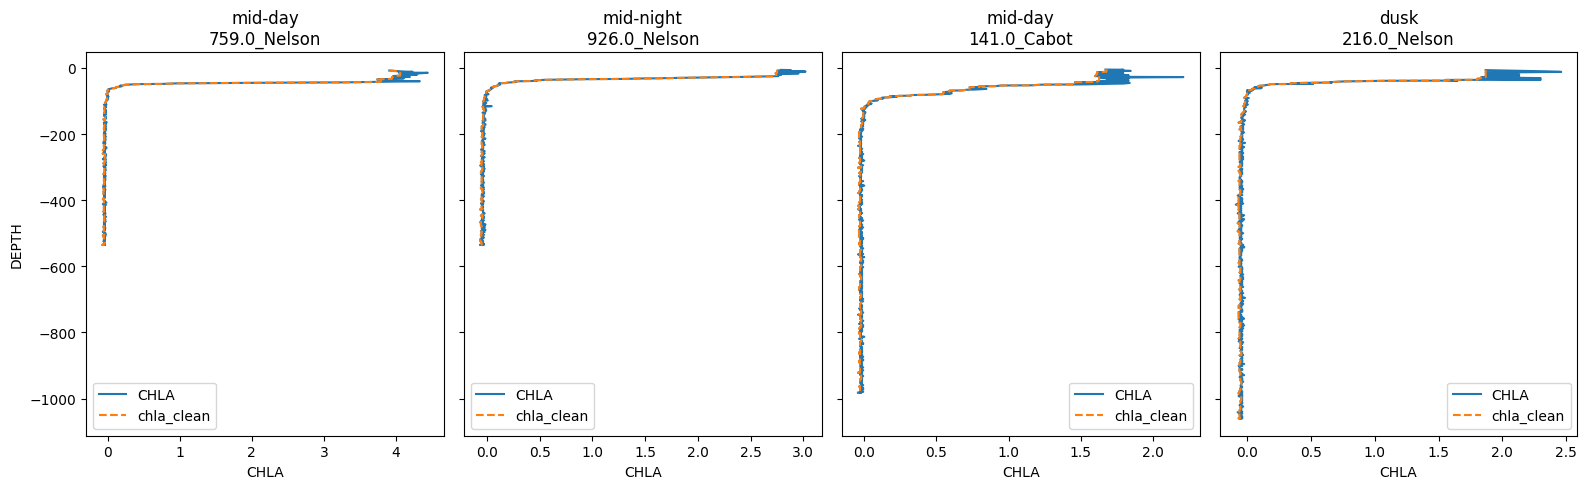

In [24]:
import numpy as np

# Get one random profile_id for each day_period
selected_profiles = []
for period in ["mid-day", "mid-night", "dawn", "dusk"]:
    ids = (
        df_with_sun
        .filter(pl.col("day_period") == period)
        .select("profile_id")
        .unique()
        .to_series()
        .to_list()
    )
    if ids:
        selected_profiles.append(np.random.choice(ids))

# Plot CHLA and chla_clean vs DEPTH for each selected profile
fig, axs = plt.subplots(1, 4, figsize=(16, 5), sharey=True)
for i, (profile_id, ax) in enumerate(zip(selected_profiles, axs)):
    prof = df_with_sun.filter(pl.col("profile_id") == profile_id)
    ax.plot(prof["CHLA"], prof["DEPTH"], label="CHLA", color="tab:blue")
    ax.plot(prof["chla_clean"], prof["DEPTH"], label="chla_clean", color="tab:orange", linestyle="--")
    ax.set_title(f"{prof['day_period'][0]}\n{profile_id}")
    ax.invert_yaxis()
    if i == 0:
        ax.set_ylabel("DEPTH")
    ax.set_xlabel("CHLA")
    ax.legend()

plt.tight_layout()
plt.show()

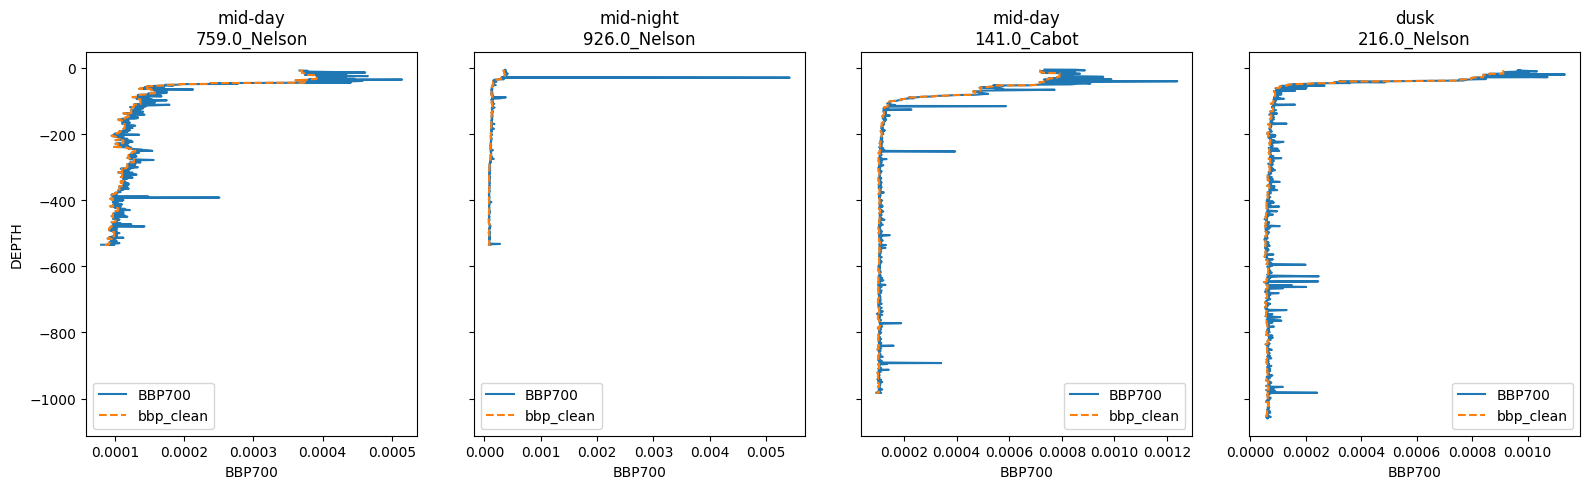

In [26]:
# Plot BBP700 and bbp_clean vs DEPTH for each selected profile
fig, axs = plt.subplots(1, 4, figsize=(16, 5), sharey=True)
for i, (profile_id, ax) in enumerate(zip(selected_profiles, axs)):
    prof = df_with_sun.filter(pl.col("profile_id") == profile_id)
    ax.plot(prof["BBP700"], prof["DEPTH"], label="BBP700", color="tab:blue")
    ax.plot(prof["bbp_clean"], prof["DEPTH"], label="bbp_clean", color="tab:orange", linestyle="--")
    ax.set_title(f"{prof['day_period'][0]}\n{profile_id}")
    ax.invert_yaxis()
    if i == 0:
        ax.set_ylabel("DEPTH")
    ax.set_xlabel("BBP700")
    ax.legend()

plt.tight_layout()
plt.show()